<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab2_Electron/blob/main/Lab2_Thomson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab2 Electron in fields, Part III: data analysis

Evgeny Kolonsky, Apr - May 2023

[Part I](https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/Lab2_Thomson.ipynb): Reproduce vendor's experiments.

[Part II](https://github.com/evgeny-kolonsky/Lab2_Electron/tree/main/CollectData) Collect data.

In [1]:
import numpy as np # math functions
import pandas as pd
import scipy # scientific functions
from scipy.stats import linregress
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import skimage
import numpy.polynomial.polynomial as poly
import itertools

Literature value
$$
{e\over m} = 1.7588 \cdot 10^{11} {C \over \text{kg}}
$$

In [2]:
N = 320 # Helmholz ring coils
R = 6.7e-2 # Helmholz ring raduis
mu0 = scipy.constants.mu_0
k2 = (4/5)**1.5
d = 5.5e-2 # distance between plates in Thomson tube
em_reference = 1.7588e11 # C/kg

UA_MIN = 2.0e3 #kV Ua acceleration voltage should be big enough, > 2kV. Explained below.
I_MIN = 0.15 # Current should be big enough, > 0.15 A. Explained below

# parameters for uncertainty calculations

U_accuracy = 0.1e3 /2 # kV # Digital screen of High Voltage Power Source is  x.x kV
I_accuracy = 1e-3 /2  #mA





## Define class and read data

In [3]:
url = r'https://raw.githubusercontent.com/evgeny-kolonsky/Lab2_Electron/main/CollectData/'
github_url = 'https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/CollectData/'

class observation:
    num = 0
    Ua = 0
    Up = 0
    I = 0
    x = np.array([])
    y = np.array([])
    image = 0
    pngname = ''
    group = ''
    p = 0 # polynomial approximation
    curvature = 0 #  = 1/r, r - radius
    k1 = 0 # E = k1 * Up/d, losses
    em = 0
    em_uncertainty = 0


    def __init__(self, num, group, Ua, Up, I, x, y):
        self.num = num
        self.group  = group
        self.Ua = Ua
        self.Up = Up
        self.I = I
        self.x = x
        self.y = y
        self.fit()

    def get_image(self):
        self.pngname = pngfiles[self.num]
        self.image = skimage.io.imread(url + self.pngname)

    def show(self):
        x_ = self.x
        y_ = self.y
        p_ = self.p # polynomial 3rd degree fit
        Ua_ = self.Ua
        Up_ = self.Up
        I_ = self.I


        fig, ax = plt.subplots(figsize=(8,5))

        fig.suptitle(f'#{self.num:n} Deflection at Ua = {Ua_*1e-3:.1f} kV, Up = {Up_*1e-3:.1f} kV, I = {I_*1e3:.0f} mA')

        self.get_image()
        axins = ax.inset_axes([.6, .63, .4, .4])
        axins.imshow(self.image)
        axins.axis('off')

        ax.scatter(x_, y_, color='gray')
        ax.plot(x_, p_(x_), color='green')
        ax.grid()
        plt.xlabel('x, m')
        plt.gca().set_xlim([9.e-2, 1.e-2]) # invert direction: from right to left
        plt.ylabel('y, m')
        plt.gca().set_ylim([-2.5e-2, 2.5e-2])
        plt.show();

    def fit(self):
        self.p = poly.Polynomial.fit(self.x, self.y, deg=3)
        p1 = self.p.deriv(1)
        p2 = self.p.deriv(2)
        curv = np.abs(p2(self.x) / (1 + p1(self.x)**2) **1.5)
        self.curvature = curv.mean()
        self.curvature_uncertainty = curv.std()/curv.mean()
        if self.Up != 0:
          yu = self.y /self.Up
          xu = self.x**2 /4/self.Ua/d
          lr = linregress(xu, yu)
          self.k1 = lr.slope





#images
soup = BeautifulSoup(requests.get(github_url).text, 'html.parser')
pngfiles = {}
for i in soup.find_all(title=re.compile("\.png$")):
        fname = i.extract().get_text()
        s = fname[:3]
        if s.isdigit():
            pngfiles[int(s)] = fname.replace(' ', '%20')


#experiments
file = 'experiments.csv'
params = pd.read_csv(url + file, index_col='Num')

#datapoints
measurements = ''
file = 'data.txt'
text = requests.get(url+file).text.splitlines()
for line in text:
  ns, xs, ys = line.split('\t')
  if ns != '':
    num = int(ns)
    Ua = params.loc[num]['Ua']
    Up = params.loc[num]['Up']
    I = params.loc[num]['I']
    continue
  else:
    x = np.float32(xs)
    y = np.float32(ys)
  measurements += f'{num} {x} {y} {Ua} {Up} {I}\n'

data = np.genfromtxt(measurements.splitlines(), dtype=float)

num, x, y, Ua, Up, I = data.T

Ua = Ua*1e3 #kV
Up = Up*1e3 #kV
x = x*1e-2 # cm
y = y*1e-2 # cm

#objects

experiment = {}
for n in np.unique(num):
  filter = (num == n)
  x_ = x[filter]
  y_ = y[filter]

  Ua_ = Ua[filter][0]
  Up_ = Up[filter][0]
  I_  = I[filter][0]

  if (Up_ == 0) & (I_ == 0):
    group = 'Z' # Zero forces
  elif (Up_ != 0) & (I_ == 0):
    group = 'E' # Electron in electrostatic field
  elif (Up_ == 0) & (I_ != 0):
    group = 'B' # Electron in magnetic field
  else:
    group = 'W' # Wien filter

  obs = observation(n, group, Ua_, Up_, I_, x_, y_)
  experiment[n] = obs



## Sample plot

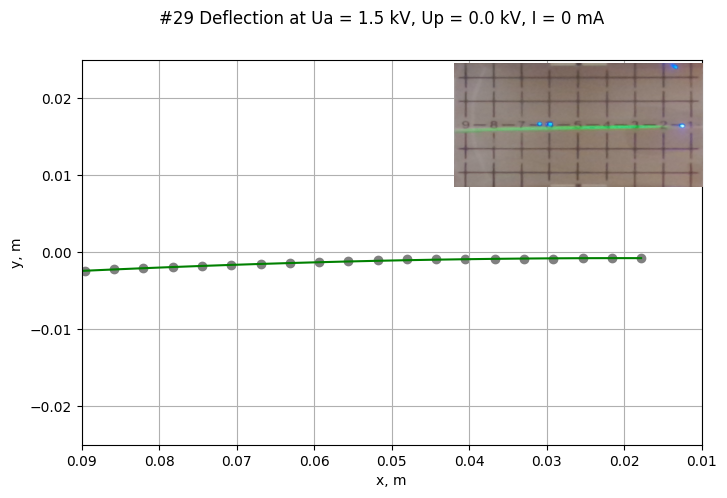

In [4]:
experiment[29].show()

# Zero correction

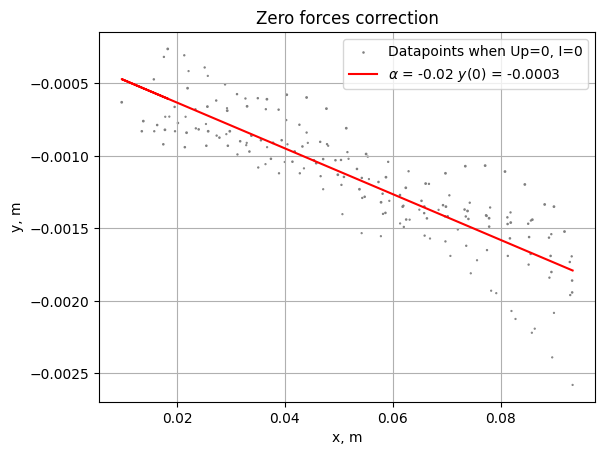

In [5]:
noforces = (Up == 0) & (I == 0)
x_ = x[noforces]
y_ = y[noforces]
Ua_ = Ua[noforces] *1e-3
plt.scatter(x_, y_, marker='.', color = 'gray',
            s=Ua_,  label='Datapoints when Up=0, I=0')

fit = linregress(x_, y_)
alpha = fit.slope
plt.plot(x_, fit.intercept + fit.slope*x_, color='red', label=fr'$\alpha$ = {alpha:.2f} $y(0)$ = {fit.intercept:.4f} ')
plt.grid()
plt.xlabel('x, m')
plt.ylabel('y, m')
plt.legend()
plt.title('Zero forces correction');


Rotate by $\alpha$ to ensure $y=0$ when no forces applied.

In [6]:
cosa, sina = np.cos(alpha), np.sin(alpha)
x, y = x*cosa + y*sina, -x*sina + y*cosa

for obs in experiment.values():
  x_, y_ = obs.x, obs.y
  obs.x, obs.y = x_*cosa + y_*sina, -x_*sina + y_*cosa
  obs.fit()

### Losses $k_1$ sample plot

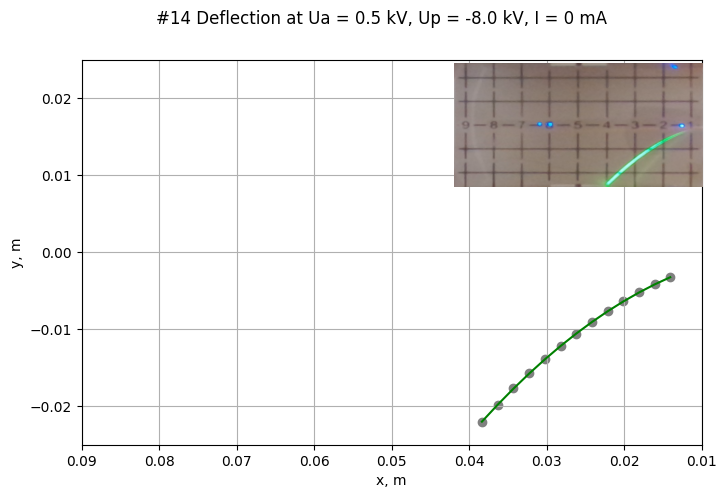

LinregressResult(slope=0.2022561414996094, intercept=5.4134307315555006e-08, rvalue=0.9999612059137235, pvalue=5.8241178424614115e-24, stderr=0.0005371749759500301, intercept_stderr=4.1209770331495305e-09)


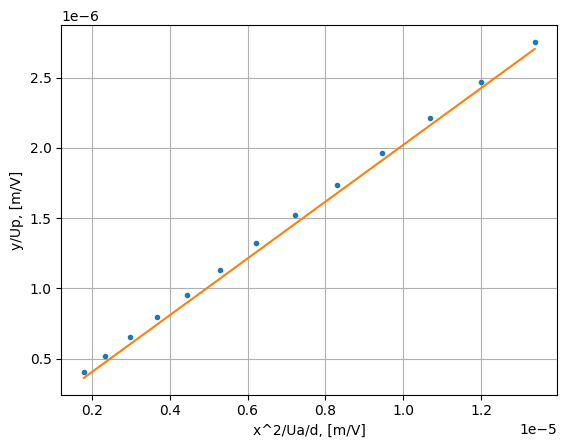

In [7]:
e14 = experiment[14]

e14.show()


yu = e14.y / e14.Up
xu = e14.x**2 /4/e14.Ua/d
lr = linregress(xu, yu)
print(lr)

plt.plot(xu, yu, '.', label='measurements')
plt.plot(xu, xu*e14.k1, '-', label='k1 fit')
plt.grid()
plt.xlabel('x^2/Ua/d, [m/V]')
plt.ylabel('y/Up, [m/V]')
plt.show()

# E-experiment

num:0, Ua: 0.5 kV, Up: -0.4 kV, k1: 0.752
num:1, Ua: 0.5 kV, Up: -0.6 kV, k1: 0.657
num:2, Ua: 0.5 kV, Up: -0.8 kV, k1: 0.572
num:3, Ua: 0.5 kV, Up: -1.0 kV, k1: 0.530
num:4, Ua: 0.5 kV, Up: -1.5 kV, k1: 0.460
num:5, Ua: 0.5 kV, Up: -2.0 kV, k1: 0.420
num:6, Ua: 0.5 kV, Up: -2.5 kV, k1: 0.386
num:7, Ua: 0.5 kV, Up: -3.0 kV, k1: 0.357
num:8, Ua: 0.5 kV, Up: -3.5 kV, k1: 0.332
num:9, Ua: 0.5 kV, Up: -4.0 kV, k1: 0.310
num:10, Ua: 0.5 kV, Up: -4.5 kV, k1: 0.286
num:11, Ua: 0.5 kV, Up: -5.0 kV, k1: 0.271
num:12, Ua: 0.5 kV, Up: -6.0 kV, k1: 0.246
num:13, Ua: 0.5 kV, Up: -7.0 kV, k1: 0.222
num:14, Ua: 0.5 kV, Up: -8.0 kV, k1: 0.202
num:15, Ua: 0.5 kV, Up: -9.0 kV, k1: 0.186
num:16, Ua: 1.0 kV, Up: -1.0 kV, k1: 0.662
num:17, Ua: 1.0 kV, Up: -1.5 kV, k1: 0.621
num:18, Ua: 1.0 kV, Up: -2.0 kV, k1: 0.553
num:19, Ua: 1.0 kV, Up: -2.5 kV, k1: 0.523
num:20, Ua: 1.0 kV, Up: -3.0 kV, k1: 0.500
num:21, Ua: 1.0 kV, Up: -3.5 kV, k1: 0.475
num:22, Ua: 1.0 kV, Up: -4.0 kV, k1: 0.452
num:23, Ua: 1.0 kV, U

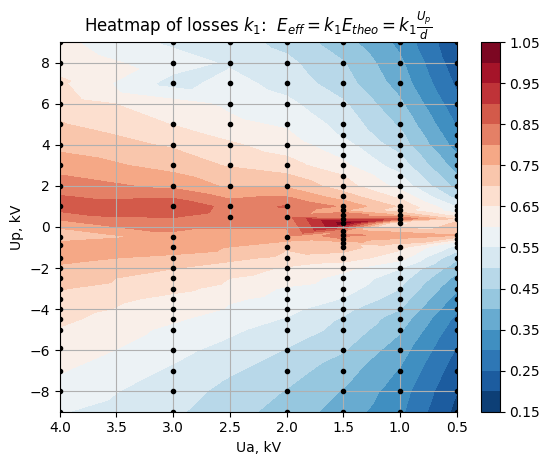

In [8]:
measurements = ''
for obs in experiment.values():
  if obs.group == 'E':
        print(f'num:{obs.num:n}, Ua: {obs.Ua*1e-3:.1f} kV, Up: {obs.Up*1e-3:.1f} kV, k1: {obs.k1:.3f}')
        measurements += f'{obs.Ua} {obs.Up} {obs.k1}\n'

data = np.genfromtxt(measurements.splitlines(), dtype=float)

Ua_, Up_, k1_ = data.T

# could be used instead of constant k1
k1_interp = LinearNDInterpolator(list(zip(Ua_, Up_)), k1_)

Ua_ *= 1e-3
Up_ *= 1e-3

plt.tricontourf(Ua_, Up_, k1_, levels=19,  cmap="RdBu_r")
plt.plot(Ua_, Up_, 'ko', ms=3)
plt.xlim(4, .5)
plt.grid()
plt.colorbar()
plt.xlabel('Ua, kV')
plt.ylabel('Up, kV')
plt.title(r'Heatmap of losses $k_1$:  $E_{eff} = k_1 E_{theo} = k_1 \frac{U_p}{d}$');

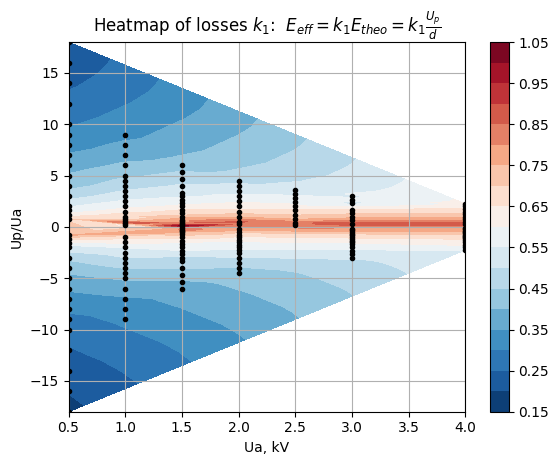

In [9]:
plt.tricontourf(Ua_, Up_/Ua_, k1_, levels=19,  cmap="RdBu_r")
plt.plot(Ua_, Up_/Ua_, 'ko', ms=3)
plt.grid()
plt.colorbar()
plt.xlabel('Ua, kV')
plt.ylabel('Up/Ua')
plt.title(r'Heatmap of losses $k_1$:  $E_{eff} = k_1 E_{theo} = k_1 \frac{U_p}{d}$');

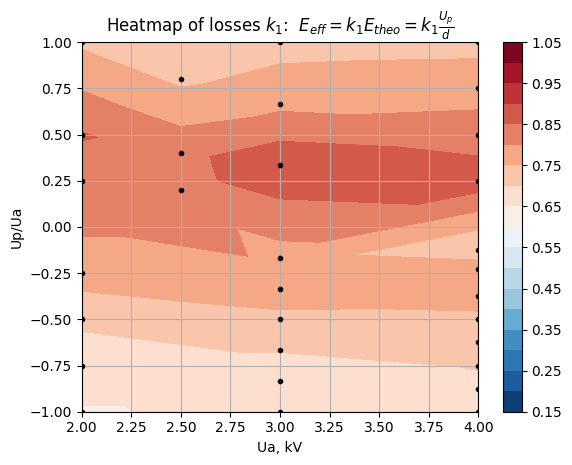

In [10]:
plt.tricontourf(Ua_, Up_/Ua_, k1_, levels=19,  cmap="RdBu_r")
plt.plot(Ua_, Up_/Ua_, 'ko', ms=3)
plt.xlim(2, 4)
plt.ylim(-1, 1)
plt.grid()
plt.colorbar()
plt.xlabel('Ua, kV')
plt.ylabel('Up/Ua')
plt.title(r'Heatmap of losses $k_1$:  $E_{eff} = k_1 E_{theo} = k_1 \frac{U_p}{d}$');

The Loss Coefficient $k_1$ is not a constant $k_1 = 0.75$ for the device, as written by vendor, but changes essentially with $U_a$ and $U_p$. The accuracy of determination ${e \over m}$ depends on ${k_1}^2$ (see section W). To achieve better accuracy of ${e \over m}$ determination, the researcher should either limit parameter's $(U_a, U_p)$ subspace, or consider $k_1$ as a function of $(U_a, U_p)$.

Here we consider $k_1$ as a constant calculated on a parameter's subspace
$$ U_a >= \text{2 kV}.$$

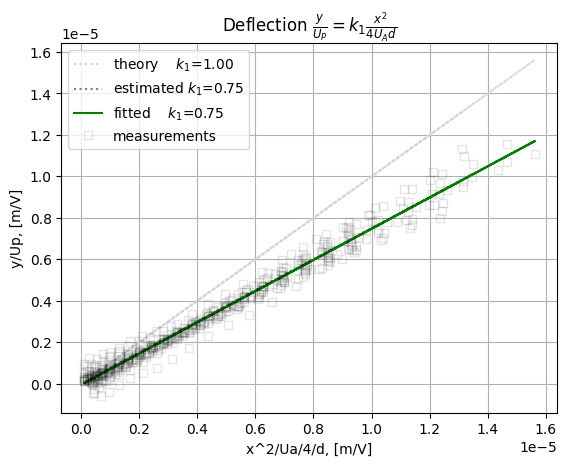

In [11]:
filter =(Up != 0) & (I == 0) # E-experiment
filter = filter * (Ua > UA_MIN)
filter = filter *  (np.abs(Up) <= Ua)

x_ = x[filter]
y_ = y[filter]
Up_ = Up[filter]
Ua_ = Ua[filter]

xu = x_*x_/Ua_/4/d
yu = y_/Up_


fit = linregress(xu, yu)
k1 = fit.slope
err_k1 = fit.stderr

plt.plot(xu, 1.00*xu, label=f'theory    $k_1$={1.0:.2f}',c='lightgray', ls='dotted')
plt.plot(xu, 0.75*xu, label=f'estimated $k_1$={.75:.2f}',c='gray', ls='dotted')
plt.plot(xu, fit.intercept + fit.slope*xu,
                      label=f'fitted    $k_1$={fit.slope:.2f}',c='green')
plt.plot(xu, yu, label='measurements', c='black',
            marker='s', fillstyle='none', ls='', alpha=.1)
plt.legend()
plt.grid()
plt.xlabel('x^2/Ua/4/d, [m/V]')
plt.ylabel('y/Up, [m/V]')
plt.title(r'Deflection $\frac{y}{U_P} = k_1 \frac{x^2}{4 U_A d}$');

In [12]:
measurements = ''
for obs in experiment.values():
  if obs.group == 'E':
        if (obs.Ua >= 2e3) & (np.abs(obs.Up) <= obs.Ua):
          print(f'num:{obs.num:n}, Ua: {obs.Ua*1e-3:.1f} kV, Up: {obs.Up*1e-3:.1f} kV, k1: {obs.k1:.3f}')
          measurements += f'{obs.Ua} {obs.Up} {obs.k1}\n'

data = np.genfromtxt(measurements.splitlines(), dtype=float)

Ua_, Up_, k1_ = data.T

num:48, Ua: 2.0 kV, Up: -0.5 kV, k1: 0.780
num:49, Ua: 2.0 kV, Up: -1.0 kV, k1: 0.704
num:50, Ua: 2.0 kV, Up: -1.5 kV, k1: 0.690
num:51, Ua: 2.0 kV, Up: -2.0 kV, k1: 0.644
num:63, Ua: 3.0 kV, Up: -0.5 kV, k1: 0.780
num:64, Ua: 3.0 kV, Up: -1.0 kV, k1: 0.787
num:65, Ua: 3.0 kV, Up: -1.5 kV, k1: 0.734
num:66, Ua: 3.0 kV, Up: -2.0 kV, k1: 0.702
num:67, Ua: 3.0 kV, Up: -2.5 kV, k1: 0.671
num:68, Ua: 3.0 kV, Up: -3.0 kV, k1: 0.666
num:79, Ua: 4.0 kV, Up: -0.5 kV, k1: 0.696
num:80, Ua: 4.0 kV, Up: -0.9 kV, k1: 0.795
num:81, Ua: 4.0 kV, Up: -1.5 kV, k1: 0.769
num:82, Ua: 4.0 kV, Up: -2.0 kV, k1: 0.740
num:83, Ua: 4.0 kV, Up: -2.5 kV, k1: 0.727
num:84, Ua: 4.0 kV, Up: -3.0 kV, k1: 0.703
num:85, Ua: 4.0 kV, Up: -3.5 kV, k1: 0.690
num:86, Ua: 4.0 kV, Up: -4.0 kV, k1: 0.670
num:145, Ua: 2.0 kV, Up: 0.5 kV, k1: 0.831
num:146, Ua: 2.0 kV, Up: 1.0 kV, k1: 0.853
num:147, Ua: 2.0 kV, Up: 2.0 kV, k1: 0.741
num:156, Ua: 2.5 kV, Up: 0.5 kV, k1: 0.826
num:157, Ua: 2.5 kV, Up: 1.0 kV, k1: 0.833
num:158, Ua

In [13]:
k1, k1_err = np.mean(k1_), np.std(k1_)
k1_uncertainty = k1_err / k1
print(f'k1= {k1:.2f} +/- {k1_uncertainty:.0%}')

k1= 0.75 +/- 9%


# B-experiment

### Measure $k_2$ value for the Helmolz rings

$$ B = k_2 \mu_0 \frac{NI}{R}$$

| direction 1 | direction 2
| :-:         | :-:
| <img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/helmholz1.jpg?raw=true" width=500> | <img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/helmholz2.jpg?raw=true" width=500>

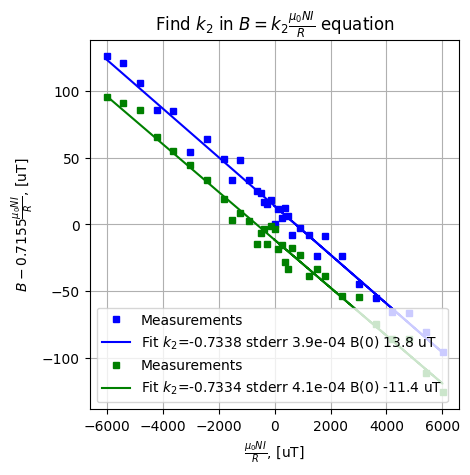

In [14]:
measurements ='''
1 .0     .0
1 .0236 -.09
1 .043  -.18
1 .0634 -.26
1 .083  -.35
1 .103  -.45
1 .153  -.66
1 .203  -.88
1 .253 -1.11
1 .303 -1.31
1 .402 -1.75
1 .502 -2.20
1 .602 -2.64
1 .702 -3.08
1 .802 -3.51
1 .901 -3.95
1 1.0  -4.39
1 -.0236 .12
1 -.043  .20
1 -.0636 .29
1 -.083  .38
1 -.1036 .47
1 -.153  .69
1 -.203  .92
1 -.253 1.12
1 -.303 1.35
1 -.402 1.79
1 -.502 2.21
1 -.602 2.67
1 -.702 3.10
1 -.802 3.55
1 -.901 3.99
1 -1.0  4.42
2 .0     -.003
2 .0236 -.12
2 .043  -.20
2 .0634 -.30
2 .083  -.39
2 .103  -.46
2 .153  -.68
2 .203  -.91
2 .253 -1.12
2 .303 -1.34
2 .402 -1.78
2 .502 -2.21
2 .602 -2.66
2 .702 -3.10
2 .802 -3.53
2 .901 -3.98
2 1.0  -4.42
2 -.0236 .10
2 -.043  .17
2 -.0636 .27
2 -.083  .35
2 -.1036 .43
2 -.153  .66
2 -.203  .88
2 -.253 1.09
2 -.303 1.32
2 -.402 1.76
2 -.502 2.20
2 -.602 2.64
2 -.702 3.08
2 -.802 3.53
2 -.901 3.96
2 -1.0  4.39
'''

data = np.genfromtxt(measurements.splitlines(), dtype=float)
direction, I, B = data.T
I = I*1 #A
B = B*1e3 #mT -> uT
im = mu0*N*I/R *1e6 #uT
k_theor = -.8**1.5
colors = itertools.cycle(('blue', 'green'))

for filter in [direction == 1, direction ==2]:
  I_ = I[filter]
  im_ = im[filter]
  B_ = B[filter]
  clr = next(colors)
  plt.plot(im_, B_ - k_theor *im_, marker='s', ls='', ms=4, c=clr,  label = 'Measurements')
  fit = linregress(im_, B_)
  k2 = fit.slope
  plt.plot(im_, fit.intercept + (k2 - k_theor) *im_, c=clr,
          label=rf'Fit $k_2$={fit.slope:.4f} stderr {fit.stderr:.1e} B(0) {fit.intercept:.1f} uT')

plt.xlabel(r'$\frac{\mu_0 N I}{R}$, [uT]')
plt.ylabel(r'$B - 0.7155 \frac{\mu_0 N I}{R}$, [uT]')
plt.gca().set_box_aspect(1)
plt.grid()
plt.legend()
plt.title(r'Find $k_2$ in $B = k_2  \frac{\mu_0 N I}{R}$ equation');



A bias from zero depends on direction and could be explained by magnetic field of Earth, which is ~30 uT [check here](https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm).

### Check B-field uniformity in [Helmholz rings](https://en.wikipedia.org/wiki/Helmholtz_coil)

[Numerical solution](https://github.com/jegarfa/Magnetic-field-Helmholtz-Maxwell-coils/blob/09ce16e1f95debe159ea932492f3f8e2b97c47a4/Magnetic_field_Helmholtz_and_Maxwell_coils.ipynb)

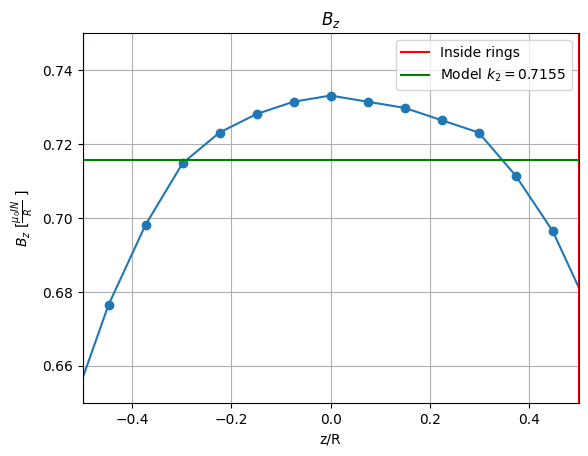

In [15]:
# along z-axis
I_ = 1.00 #A
measurements = '''
-100 1.22
-90 1.49
-80 1.86
-70 2.30
-60 2.78
-50 3.29
-40 3.72
-30 4.06
-25 4.19
-20   4.29
-15 4.34
-10   4.37
-5   4.39
0 4.40
5 4.39
10 4.38
15 4.36
20 4.34
25 4.27
30 4.18
40 3.92
50 3.50
60 3.05
70 2.57
80 2.09
90 1.71
100 1.37
'''
data = np.genfromtxt(measurements.splitlines(), dtype=float)
z_, B_ = data.T
z_ *= 1e-3 #mm
B_ *= 1e-3 #mT

munir_ = mu0 *N *I_ /R

z_ /= R
B_ /= munir_

plt.plot(z_, B_, 'o-')
plt.xlabel('z/R')
plt.xlim(-.5, .5)
plt.ylim(.65, .75)
plt.axvline(x=-.5, color='red', label='Inside rings')
plt.axvline(x=.5, color='red')
plt.axhline(y=.8**1.5, color='green', label='Model $k_2 = 0.7155$')
plt.ylabel(r'$B_z$ [$\frac{\mu_0 I N} {R}$ ]')
plt.title('$B_z$')
plt.grid()
plt.legend()


In [16]:
k2_ = B_[np.abs(z_)<.5]
k2, k2_err = np.mean(k2_), np.std(k2_)
k2_uncertainty = k2_err / k2
print(f'k2 = {k2:.2f} +/- {k2_uncertainty:.0%}')
#k2_ = B_[np.abs(z_)<.5]
#k2_uncertainty = B_[np.abs(z_)<.5].std()/k2
#k2, k2_uncertainty

k2 = 0.72 +/- 2%


We will use theoretical value of $k_2 = 0.7155 ± 2\%$.

In [17]:
# Systematic error in B
B_earth = 30 *1e-6 # uT

### B-experiment analysis

$$
B =  k_2 \cdot \mu_0 {N I\over R},
\tag{4}
$$

$$
{e \over m} = {2U_A\over (B\cdot r)^2},
\tag{5}
$$

$$
\text{curvature} = {1\over r} = {y'' \over (1 + y'^2)^{3\over 2}}
$$


In [18]:
measurements =''
for obs in experiment.values():
  if obs.group == 'B':

    #if np.abs(obs.I) <I_MIN:
    #  continue
    #if obs.Ua <UA_MIN:
    #  continue

    B = k2 * mu0 * N /R * obs.I
    r = 1/ obs.curvature
    obs.em = 2*obs.Ua /(B * r)**2

    # uncertainties
    delta_Ua = U_accuracy / UA_MIN
    delta_I = I_accuracy / I_MIN
    delta_k2 = k2_uncertainty # 2.3%
    delta_r = obs.curvature_uncertainty
    delta_B_systematic = B_earth / np.abs(B)
    B_uncertainty =  delta_B_systematic + delta_I + k2_uncertainty
    delta_em = np.sqrt(delta_Ua**2 + 4* B_uncertainty**2 + 4*delta_r**2)
    obs.em_uncertainty = delta_em

    print(fr'num:{obs.num:n}, Ua: {obs.Ua*1e-3:.1f} kV, I: {obs.I*1e3:-.0f} mA, r: {r*1e2:.1f} ±{obs.curvature_uncertainty:.0%} cm, B:{B*1e3:.3f} ±{B_uncertainty:.0%} mT , em:{obs.em:.2e} ±{obs.em_uncertainty:.0%} C/kg')
    measurements += f'{obs.Ua} {obs.I} {obs.em} {obs.em_uncertainty} {B}\n'

data = np.genfromtxt(measurements.splitlines(), dtype=float)
data = data[data[:, 1].argsort()] # sort by I

Ua_, I_, em_, delta_em_, B_, = data.T

uncertainty_weights = 1 /delta_em_**2
uncertainty_weights /= uncertainty_weights.sum()
em_weighted = np.sum(em_ * uncertainty_weights)

total_uncertainty = np.sum(delta_em_**-2)**-.5

print(f'Average e/m:{em_weighted:.2e} ±{total_uncertainty:.0%} C/kg')


num:200, Ua: 1.0 kV, I: 50 mA, r: 51.0 ±7% cm, B:0.215 ±17% mT , em:1.66e+11 ±36% C/kg
num:201, Ua: 1.0 kV, I: 100 mA, r: 25.2 ±13% cm, B:0.430 ±10% mT , em:1.70e+11 ±33% C/kg
num:202, Ua: 1.0 kV, I: 150 mA, r: 16.6 ±23% cm, B:0.646 ±7% mT , em:1.74e+11 ±49% C/kg
num:203, Ua: 1.0 kV, I: 200 mA, r: 10.7 ±45% cm, B:0.861 ±6% mT , em:2.34e+11 ±91% C/kg
num:204, Ua: 1.0 kV, I: 250 mA, r: 9.4 ±9% cm, B:1.076 ±5% mT , em:1.96e+11 ±21% C/kg
num:205, Ua: 2.0 kV, I: 50 mA, r: 74.7 ±19% cm, B:0.215 ±17% mT , em:1.55e+11 ±50% C/kg
num:206, Ua: 2.0 kV, I: 100 mA, r: 34.9 ±34% cm, B:0.430 ±10% mT , em:1.77e+11 ±70% C/kg
num:207, Ua: 2.0 kV, I: 150 mA, r: 22.0 ±10% cm, B:0.646 ±7% mT , em:1.99e+11 ±25% C/kg
num:208, Ua: 2.0 kV, I: 200 mA, r: 19.6 ±40% cm, B:0.861 ±6% mT , em:1.40e+11 ±81% C/kg
num:209, Ua: 2.0 kV, I: 250 mA, r: 15.6 ±36% cm, B:1.076 ±5% mT , em:1.41e+11 ±74% C/kg
num:210, Ua: 3.0 kV, I: 50 mA, r: 86.6 ±28% cm, B:0.215 ±17% mT , em:1.73e+11 ±66% C/kg
num:211, Ua: 3.0 kV, I: 100 mA, r

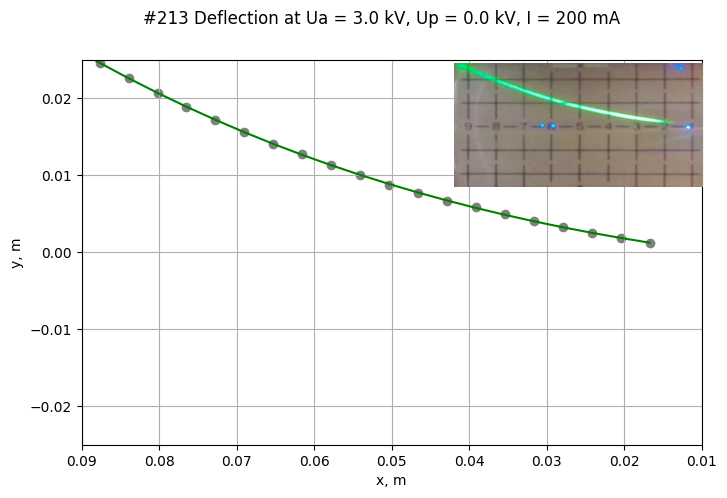

In [19]:
obs = experiment[213]
obs.show()

Text(0.5, 1.0, 'Results of B-experiments, one point - one experiment')

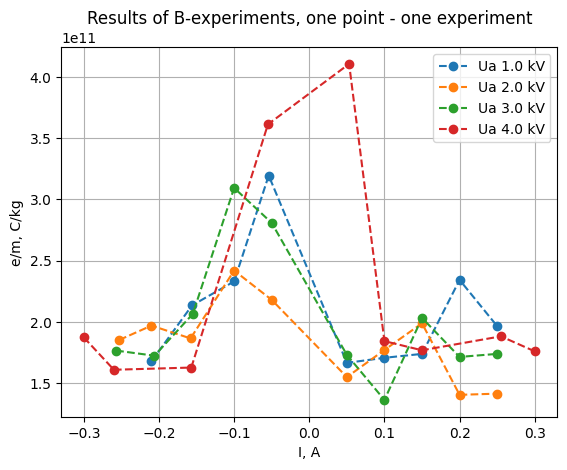

In [20]:
for option in np.unique(Ua_):
  plt.plot(I_[Ua_==option],em_[Ua_==option], 'o--', label=f'Ua {option*1e-3:.1f} kV')

plt.legend()
plt.xlabel('I, A')
plt.ylabel('e/m, C/kg')
plt.grid()
plt.title('Results of B-experiments, one point - one experiment')


We see anomaly near $I=0$: Non-Symmetry at zero point and some increase of $e/m$. Can it be explained by the Earth magnetic field?

### Earth magnetic field influence

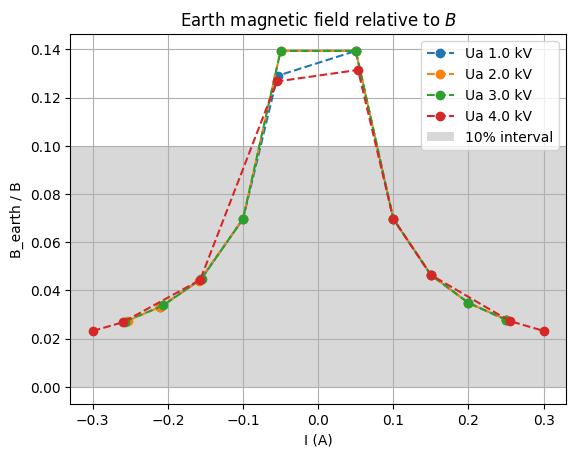

In [21]:
B_earth = 30e-6 #uT
fig, ax = plt.subplots()

for option in np.unique(Ua_):
  plt.plot(I_[Ua_==option],np.abs(B_earth /B_[Ua_==option]) , 'o--', label=f'Ua {option*1e-3:.1f} kV')

ax.axhspan(0, .1, alpha=.3, facecolor='.5', label='10% interval')

plt.legend()
ax.set(xlabel='I (A)', ylabel='B_earth / B', title='Earth magnetic field relative to $B$')
ax.grid()
plt.show();


For small $I$ the relative influence of $B_{earth}$ to $B$ becomes big enough to spoil the results accuracy. The researcher should keep $B$ more than ten times of $B_{earth}$. For pair of Helmholz rings used in the experiment currents should be not less that 100 - 150 mA.

### B-experiment uncertainties calculations

Electron Charge to Mass Ratio e/m
J. Lukens, B. Reid, A. Tuggle
PH 235-001, Group 4
18 January 2010
[.pdf 3.2 Uncertainties calculations](http://pleclair.ua.edu/PH255/templates/e-m/charge2mass.pdf)



$$
{e \over m} = {2U_A k_2 R\over (N \mu_0 I\cdot r)^2},
\tag{5}
$$
where $U_A$, $I$, $r$ are measured in the experiment, $k_2$ has known uncertainty $2\%$, other values are constants.

Using sign $\delta$ for relative uncertainty $\delta X = {std X \over mean X}$ we have
$$
\delta (e/m) = \sqrt{\delta {U_A} ^2 + (2 \delta I)^2 + (2\delta r)^2 + \delta{k_2}^2}
$$

In [22]:
delta_Ua = U_accuracy / UA_MIN
delta_I = I_accuracy / I_MIN
delta_k2 = 2.3e-2
obs  = experiment[214]
delta_r = obs.curvature_uncertainty

delta_em = np.sqrt(delta_Ua**2 + 4* delta_I**2 + 4*delta_r**2 + delta_k2**2)
delta_em
obs.em_uncerainty = delta_em

# W-experiment

In the experiment a velocity filter (Wien filter) is set up. For
the fixed anode voltage $U_A$ the voltage at the plate capacitor
$U_P$ and the current through the Helmholtz pair of coils $I$ is
selected in such a way that the deflections from the electric
and the magnetic fields just cancel each other out at the
outlet of the plate capacitor. If $U_A$ and therefore speed of the
electron is changed, it is apparent that this
compensation without a change of $U_P$ and $I$ is only possible at
a speed of $v=\sqrt{2 e U_A \over m}$ and that the electron beam is
deflected once again. Only by changing $U_P$ or $I$ can the
deflection be compensated for again.

In addition this setup allows more precise determination of
the specific electron charge. When $U_P$ and $I$ are chosen in
such a way that the electric and the magnetic field exactly
compensate the specific charge is
$$
{m v^2 \over 2} = e \cdot U_A , \quad v = {E \over B}
$$

$$
{e \over m} = {1\over 2 U_A} \left({E\over B}\right)^2
\tag{7.1}
$$


On account of the tube construction, the electric field is
smaller than the value to be expected theoretically. This can
be taken into account in the experiment by a correction factor:
$$
E_{exp} = k_1 E_{theo} = k_1 {U_P\over d}
\tag{7.2}$$


In [26]:
measurements = ''
for obs in experiment.values():
  if obs.group == 'W':
    #if (obs.Ua > UA_MIN) and (np.abs(obs.Up) <= obs.Ua) and (obs.I > I_MIN):
    if True: # take all data
      B_ = k2 * mu0 * N /R * obs.I
      B_uncertainty = np.abs(B_earth / B_) + k2_uncertainty
      #k1 = k1_interp(obs.Ua, obs.Up).tolist()
      E_ = k1 *obs.Up / d
      Up_uncertainty = U_accuracy / np.abs(obs.Up)
      Ua_uncertainty = U_accuracy / np.abs(obs.Ua)
      E_uncertainty = k1_uncertainty + Up_uncertainty
      v2_ = np.abs(E_ / B_)**2
      v2_uncertainty = 2*(E_uncertainty + B_uncertainty)
      em_ = 1/2/obs.Ua * v2_
      em_uncertainty = Ua_uncertainty + v2_uncertainty
      obs.em = em_
      obs.em_uncerainty = em_uncertainty
      r_ = 1/obs.curvature
      #print(f'num:{obs.num:n}, Ua: {obs.Ua*1e-3:.1f} kV, Up: {obs.Up*1e-3:.1f} kV I: {obs.I*1e3:-.0f} mA, B: {B_*1e3:-.3f} ±{B_uncertainty:.0%} mT, r: {1/obs.curvature*1e2:.1f} ±{obs.curvature_uncertainty:.0%} cm, v: {v_:.1e} m/c, em:{em_:.2e} ±{em_uncertainty:.0%} C/kg')
      print(f'num:{obs.num:n} ' + \
            f'Ua: {obs.Ua*1e-3:.1f} kV, Up: {obs.Up*1e-3:.1f} kV I: {obs.I*1e3:-.0f} mA, ' +\
            f'B: {B_*1e3:-.3f} ±{B_uncertainty:.0%} mT, ' +\
            f'r: {r_*1e2:.1f} cm, ' +\
            f'v: {np.sqrt(v2_):.1e} m/c,'+\
            f'em:{em_:.2e} ±{em_uncertainty:.0%} C/kg')
      measurements += f'{em_} {em_uncertainty}\n'

data = np.genfromtxt(measurements.splitlines(), dtype=float)
em_, delta_em_ = data.T

uncertainty_weights = 1 /delta_em_**2
uncertainty_weights /= uncertainty_weights.sum()
em_weighted = np.sum(em_ * uncertainty_weights)

total_uncertainty = np.sum(delta_em_**-2)**-.5

print(f'Average e/m:{em_weighted:.2e} ±{total_uncertainty:.0%} C/kg')


num:300 Ua: 1.0 kV, Up: 1.0 kV I: -152 mA, B: -0.654 ±7% mT, r: 43.0 cm, v: 2.1e+07 m/c,em:2.20e+11 ±46% C/kg
num:301 Ua: 1.0 kV, Up: 1.5 kV I: -250 mA, B: -1.076 ±5% mT, r: 30.9 cm, v: 1.9e+07 m/c,em:1.83e+11 ±39% C/kg
num:302 Ua: 2.0 kV, Up: 1.0 kV I: -110 mA, B: -0.474 ±9% mT, r: 99.6 cm, v: 2.9e+07 m/c,em:2.10e+11 ±47% C/kg
num:303 Ua: 2.0 kV, Up: 1.5 kV I: -161 mA, B: -0.693 ±7% mT, r: 56.5 cm, v: 3.0e+07 m/c,em:2.20e+11 ±40% C/kg
num:304 Ua: 2.0 kV, Up: 2.0 kV I: -214 mA, B: -0.921 ±6% mT, r: 42.0 cm, v: 3.0e+07 m/c,em:2.22e+11 ±36% C/kg
num:305 Ua: 2.0 kV, Up: 3.0 kV I: -336 mA, B: -1.446 ±4% mT, r: 32.0 cm, v: 2.8e+07 m/c,em:2.02e+11 ±32% C/kg
num:306 Ua: 3.0 kV, Up: 1.5 kV I: -121 mA, B: -0.521 ±8% mT, r: 55.9 cm, v: 4.0e+07 m/c,em:2.60e+11 ±42% C/kg
num:307 Ua: 3.0 kV, Up: 3.2 kV I: -293 mA, B: -1.261 ±5% mT, r: 38.1 cm, v: 3.5e+07 m/c,em:2.02e+11 ±31% C/kg
num:308 Ua: 4.0 kV, Up: 1.0 kV I: -81 mA, B: -0.349 ±11% mT, r: 89.7 cm, v: 3.9e+07 m/c,em:1.94e+11 ±50% C/kg
num:309 Ua

# Conclusion: the blueprint of student's experiment

1. Make **Z**-experiment to record the beam line at zero deflection forces. This will be used later when performing W-experiment.

2. Make **E**-experiment using $U_a$ > 2 kV (variant: $U_p < U_a$). Compare trajectory with parabola. At this experiment researcher finds or checks losses coefficient $k_1$ (passport value $k_1 =0.75$), which will be used later when performing W-experiment.

3. Make **B**-experiment using $I$ > 100 mA. Compare trajectory with circle. Calculate $e/m$ with confidence intervals and compare with literature value ${e_0\over m_0} = 1.7588 \cdot 10^{11} {C \over \text{kg}}$. At this experiment researcher uses $k_2$ theoretical value $k_2 =0.7155$.

4. Make **W**-experiment using $U_a$ > 2 kV and $I$ > 100 mA. At this experiment  researcher sets $U_p$ and varies $I$ to make beam as close to zero-forces line (found earlier) as possible. Calculate $e/m$, confidence interval, and compare the result with literature value and results of B-experiment.

## Relativistic effect

Classic theory

$$
\frac{mv^2}{2} = e U_a, \rightarrow v =\sqrt{2 \frac{e}{m} U_a} $$

In [24]:
Ua = 4e3 #kV
c = scipy.constants.c
# intial speed of electron
v0 = np.sqrt(2*em_reference *Ua)
print(f'v0: {v0:.2e} m/c')
print(f'c : {c:.2e} m/c')
print(f'v0/c: {v0/c:.3f}')

v0: 3.75e+07 m/c
c : 3.00e+08 m/c
v0/c: 0.125


Relativistic effect [(source)](https://virtuelle-experimente.de/en/kanone/relativistisch/relativistisch.php)
$$
v_{rel} = c \cdot \sqrt{1 - \frac{1}{\left( 1+ \frac{U_a e}{m c^2}\right)^2}}
$$

In [25]:
v_rel = c * np.sqrt(1 - 1/(1+Ua/c/c*em_reference)**2)

print(f'v_rel: {v_rel:.3e} m/c')
print(f'v_rel/v0: {v_rel/v0:.3f}')

v_rel: 3.729e+07 m/c
v_rel/v0: 0.994


**Conclusion**: Relativistic effect is negligibly small.

##  Small rings vs big rings

Compare trajectory of electron beam with the same $N_a$ and the same $B$ field for two kinds of rings.

![Fig](https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/BigRings/overview.jpg?raw=true)


|Parameters| Small rings | Big rings  
| :-:    | :-:          | :-:          
$U_a$ = 2 kV, $B$ = 0.65 mT| <img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/CollectData/207%20Ua%202.0%20Up%200.0%20I%200.150.png?raw=true" width=250>| <img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/BigRings/1a_Ua_2kV_B_65uT.jpg?raw=true" width=200>
3 kV, 0.65mT|<img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/CollectData/212%20Ua%203.0%20Up%200.0%20I%200.150.png?raw=true" width=250>|<img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/BigRings/2a_Ua_3kV_B_65uT.jpg?raw=true" width=200>
4 kV, 0.65 mT| <img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/CollectData/217%20Ua%204.0%20Up%200.0%20I%200.150.png?raw=true" width=250>|<img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/BigRings/3a_Ua_4kV_B_65uT.jpg?raw=true" width=200>
2 kV, 0.86mT | <img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/CollectData/208%20Ua%202.0%20Up%200.0%20I%200.200.png?raw=true" width=250>|<img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/BigRings/4a_Ua_2kV_B_86uT.jpg?raw=true" width=200>
3 kV, 0.86mT| <img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/CollectData/213%20Ua%203.0%20Up%200.0%20I%200.200.png?raw=true" width=250>|<img src="https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/BigRings/5a_Ua_3kV_B_86uT.jpg?raw=true" width=200>


## W-experiment with big rings

In [52]:
R1 = 0.15 #m
N1 = 124

measurements = '''
2 1 -528
3 1 -449
3 2 -858
4 1 -380
4 2 -759
4 3 -1178
2 -1 529
3 -1 469
3 -2 888
4 -1 409
4 -2 769
4 -3 1168
'''
data = np.genfromtxt(measurements.splitlines(), dtype=float)
Ua_, Up_, I_ = data.T

Ua_ *= 1e3 #kV
Up_ *= 1e3 #kV
I_ *= 1e-3 #mA

B_ = k2 * mu0 * N1 /R1 * I_
B_uncertainty = np.abs(B_earth / B_) + k2_uncertainty
E_ = k1 * Up_ / d
Up_uncertainty = U_accuracy / np.abs(Up_)
Ua_uncertainty = U_accuracy / Ua_
E_uncertainty = k1_uncertainty + Up_uncertainty
v2_ = (E_ / B_)**2
v2_uncertainty = 2*(E_uncertainty + B_uncertainty)
em_ = v2_/Ua_/2
em_uncertainty = Ua_uncertainty + v2_uncertainty

uncertainty_weights = 1 /em_uncertainty**2
uncertainty_weights /= uncertainty_weights.sum()
em_weighted = np.sum(em_ * uncertainty_weights)

total_uncertainty = np.sum(em_uncertainty**-2)**-.5

print(f'Average e/m:{em_weighted:.2e} ±{total_uncertainty:.0%} C/kg')


Average e/m:2.86e+11 ±12% C/kg


**Conclusion**: The result of W-experiment with big rings value of $e/m$ differs essentially from $e/m$ value acvieved in the same experiment with small rings. It is suggested that big rings might spoil the the purity of the experiments influencing on the beam at the initial acceleration part of the trajectory. Big rings should not be used in the experiment.